In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
df_train_est_A = pd.read_csv('train_est_B.csv')
df_train_obs_A = pd.read_csv('train_obs_B.csv')
df_test_A = pd.read_csv('X_test_B.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_est_A=df_train_est_A.drop(columns=['date_calc'])
df = pd.concat([df_train_obs_A,df_train_est_A])

In [3]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [4]:
columns = df.drop(columns = 'pv_measurement').columns

In [13]:
from sklearn.preprocessing import MinMaxScaler
# Crea un oggetto MinMaaxScaler
scaler = MinMaxScaler()
# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_normalized['pv_measurement'] = df_knn[ 'pv_measurement']

In [14]:
df = df_normalized

In [15]:
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
#df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)
df['dayofyear'] = df.index.day_of_year
df_test_A['dayofyear'] = df_test_A.index.day_of_year

In [16]:
data = df

In [17]:
model = RandomForestRegressor()

In [18]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [19]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [24]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = data['pv_measurement']


C:\Users\claxl\AppData\Local\Temp\ipykernel_32544\2409565943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['pv_measurement'] = data['pv_measurement']


In [25]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

# Sample DataFrame (replace this with your own dataset)
data = X_selected

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 2


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [17]:
def objective(trial):
    params = {
            'criterion' : 'absolute_error',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt','log2',None]),
            'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1,500),
    }
    model = RandomForestRegressor(**params)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')

        # Train the XGBoost model
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [18]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner())

[I 2023-10-26 10:28:39,450] A new study created in memory with name: no-name-c1b63805-ea3a-4961-8ffb-d9ebc4b1e0ae


In [ ]:
study.optimize(objective, n_trials=20)

In [ ]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

In [20]:
param = {'n_estimators': 18, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}

In [21]:
model_A = RandomForestRegressor(**param)

In [26]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [27]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

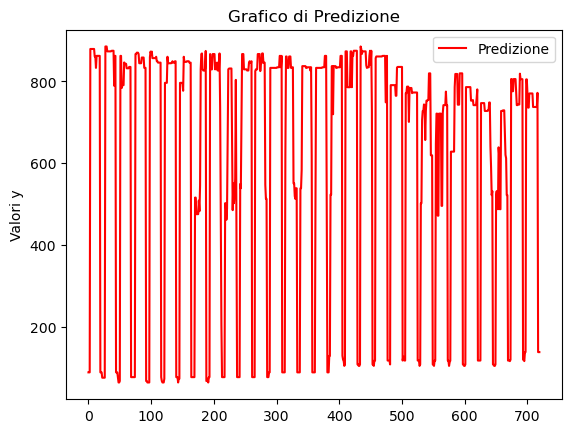

In [28]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [29]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [30]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [31]:
df.to_csv('B.csv')

In [32]:
df

,Prediction
0,88.582938
1,88.582938
2,88.582938
3,879.234247
4,879.234247
...,...
715,737.363557
716,771.976360
717,138.091236
718,138.091236
